# Scheduler 적용 기본
학습률을 동적으로 적용하기 위해 파이토치에 기본적으로 적용시키는 의사 코드(Pseudo Code)는 다음과 같습니다.
```python
import torch
from torch.optim import lr_scheduler
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(
    optimizer, # Scheduler를 적용할 Optimizer를 넣어주면 끝납니다.
    step_size=30,
    gamma=0.1
)
tbar = tqdm(dataset)
for epoch in tbar:
    train(...)
    validate(...)
    scheduler.step() # Optimizer 대신 Scheduler를 호출
```

# 데이터 준비

In [1]:
import torchvision
import torch

train_ds = torchvision.datasets.MNIST(
    root="../../data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

test_ds = torchvision.datasets.MNIST(
    root="../../data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, num_workers=2, shuffle=True  # dataset
)

test_dataloader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    num_workers=2,
    shuffle=False,  # we don't need to shuffle the test data
)

# 모델 정의

In [2]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Neural Network을 구성하는 layer들을
        # initialize하는 부분
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 784 // 4),
            nn.ReLU(),
            nn.Linear(784 // 4, 784 // 16),
            nn.ReLU(),
            nn.Linear(784 // 16, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Neural Network의 forward pass을 정의하는 부분
        # x은 input tensor
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x

In [3]:
# Optimizer의 Learning Rate를 추출하는 함수 정의 - 실험(시각화)을 위해 만듦
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

In [4]:
from tqdm import tqdm
import torch


def train_loop(model, train_dataloader, loss_fn, optimizer):
    device = next(model.parameters()).device

    train_loss_history = []
    tbar = tqdm(train_dataloader)
    model.train()

    for batch, label in tbar:
        batch = batch.to(device)
        label = label.to(device)

        pred = model(batch)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tbar.set_description(f"Train Loss: {loss.item():.4f}")
        train_loss_history.append(loss.item())

    return train_loss_history


def val_loop(model, test_dataloader, loss_fn):
    device = next(model.parameters()).device

    tbar = tqdm(test_dataloader)
    num_batches = len(test_dataloader)
    size = len(test_dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch, label in tbar:
            batch = batch.to(device)
            label = label.to(device)

            pred = model(batch)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

            tbar.set_description(f"Test Loss: {loss.item():.4f}")
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

# Step LR
Step LR Scheduler은 step_size마다 Learning Rate에 gamma을 곱해줍니다. 즉, 아래 예시에서 step_size=30, gamma=0.1의 경우 매 30 epoch마다 learning rate을 1/10으로 줄여주는 것입니다.

In [5]:
# # Step LR을 적용한 예시 코드
# # 100 epoch을 실제로 학습을 돌리기에는 학습 시간이 걸리므로 실제로 돌려보지는 않고
# # 다음 Cell에 있는 코드를 돌려서 Learning의 변화를 확인해보도록 하겠습니다.

# train_loss_history = []
# test_loss_history = []
# test_acc_history = []

# lr_list = []

# for epoch in range(100):

#     model.train()
#     # Train Loop
#     train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)

#     model.eval()
#     # Validation Loop
#     test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)

#     scheduler.step()  # Step LR의 경우, Epoch 마다 scheduler.step()을 호출해야 합니다.
#     lr_list.append(get_lr(optimizer))

In [6]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [7]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [8]:
# 실험 코드
lr_list = []

lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))  # tqdm progress bar 생성

for epoch in tbar:
    # train(...)
    # validate(...)
    # 스케쥴러 작동
    scheduler.step()

    # 스케쥴러 작동 후에 learning rate 확인
    lr_list.append(get_lr(optimizer))

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/dl-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 62770.19it/s]


Text(0, 0.5, 'LR')

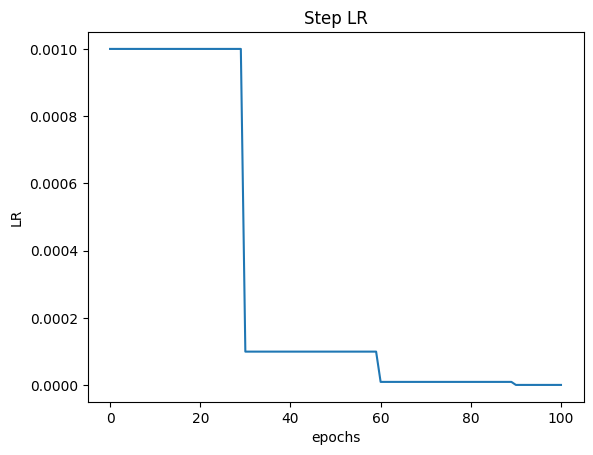

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lr_list)
plt.title("Step LR")
plt.xlabel("epochs")
plt.ylabel("LR")

# Exponential LR
Exponential LR은 매 epoch마다 Learning Rate에 gamma을 곱해줍니다. 즉, 아래 예시에서 gamma=0.9의 경우 매 epoch마다 learning rate에 0.9을 곱해줍니다.

In [10]:
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [11]:
# # Exponential LR Scheduler을 적용한 예시 코드
# # Step LR과 사용법이 동일합니다.
# # 마찬가지로 학습 시간이 조금 걸리니 실제로 돌려보지는 않고 다음 Cell에 있는 코드만 실행해주세요.

# train_loss_history = []
# test_loss_history = []
# test_acc_history = []

# lr_list = []

# for epoch in range(100):

#     model.train()
#     # Train Loop
#     train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)

#     model.eval()
#     # Validation Loop
#     test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)

#     scheduler.step()  # Step LR의 경우, Epoch 마다 scheduler.step()을 호출해야 합니다.
#     lr_list.append(get_lr(optimizer))

In [12]:
# 실험 코드
lr_list = []

lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))  # tqdm progress bar 생성

for epoch in tbar:
    # train(...)
    # validate(...)
    # 스케쥴러 작동
    scheduler.step()

    # 스케쥴러 작동 후에 learning rate 확인
    lr_list.append(get_lr(optimizer))

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/dl-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 174835.51it/s]


Text(0, 0.5, 'LR')

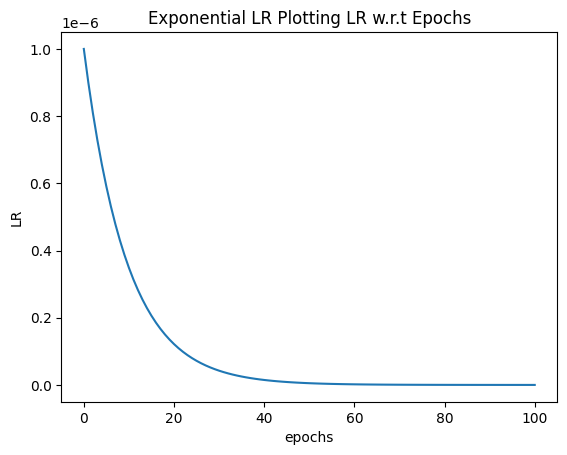

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lr_list)
plt.title("Exponential LR Plotting LR w.r.t Epochs")
plt.xlabel("epochs")
plt.ylabel("LR")

# Cosine Annealing LR
T_max의 주기를 가진 Cosine 함수로 Learning Rate을 scheduling합니다.

-  Optimizer에서 지정된 learning_rate이 곧 eta_max가 됩니다.
    - 즉, T_cur = N x T_max 때마다 learning_rate == eta_max.
- eta_min은 minimum learning rate입니다
    - 즉, T_cur = N x T_max + T_max // 2 때마다 learning_rate == eta_min.

In [14]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0)

In [15]:
# 실험 코드
lr_list = []

lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))  # tqdm progress bar 생성

for epoch in tbar:
    # train(...)
    # validate(...)
    # 스케쥴러 작동
    scheduler.step()

    # 스케쥴러 작동 후에 learning rate 확인
    lr_list.append(get_lr(optimizer))

100%|██████████| 100/100 [00:00<00:00, 184771.10it/s]


Text(0, 0.5, 'LR')

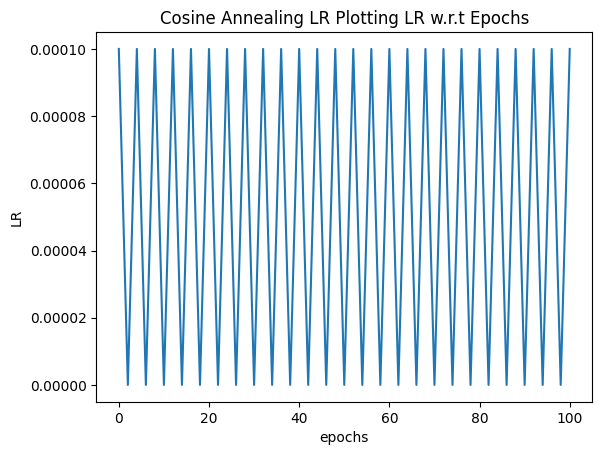

In [16]:
plt.figure()
plt.plot(lr_list)
plt.title("Cosine Annealing LR Plotting LR w.r.t Epochs")
plt.xlabel("epochs")
plt.ylabel("LR")

# Cosine Annealing with Warm Restarts LR
Cosine Annealing with Warm Restarts은 Cosine 함수로 줄어다가 다시 Max LR로 주기적으로 Restart하도록 Scheduling하는 방법입니다.

-  Optimizer에서 지정된 learning_rate이 곧 eta_max가 됩니다.
    - 즉, T_cur = N x T_max 때마다 learning_rate == eta_max.
- eta_min은 minimum learning rate입니다.
    - 즉, T_cur = N x T_max + T_max // 2 때마다 learning_rate == eta_min.

In [17]:
optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=0
)

In [18]:
# 실험 코드
lr_list = []

lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))  # tqdm progress bar 생성

for epoch in tbar:
    # train(...)
    # validate(...)
    # 스케쥴러 작동
    scheduler.step()

    # 스케쥴러 작동 후에 learning rate 확인
    lr_list.append(get_lr(optimizer))

100%|██████████| 100/100 [00:00<00:00, 150118.25it/s]


Text(0, 0.5, 'LR')

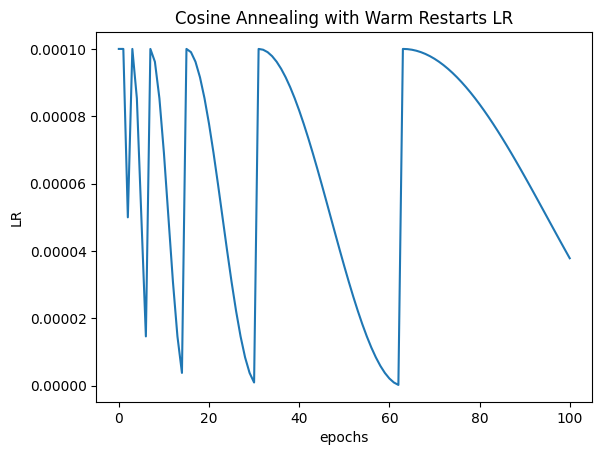

In [19]:
plt.figure()
plt.plot(lr_list)
plt.title("Cosine Annealing with Warm Restarts LR")
plt.xlabel("epochs")
plt.ylabel("LR")

# Reduce on Plateau LR
Reduece on Plateau LR은 앞에서 살펴보았던 LR Scheduler와는 다르게 특정 조건이 만족되었을 때 LR을 감소시키는 방식입니다. 이 방식은 특정 epoch동안 성능이 향상되지 않을 때 LR을 감소시키는 방식입니다.

In [21]:
optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # 모델의 지표를 확인할 기준 => loss 를 집어넣으면 loss 가 최솟값인지 확인
    factor=0.1,  # lr 를 줄일 때 곱해줄 값
    patience=10,  # mode 로 지정한 지표를 확인할 횟수 => patience 만큼의 epoch 동안 더 낮은 loss 가 확인되지 않으면 lr 에 factor 를 곱해줌
    threshold=0.001,
)

In [23]:
# # Reduce LR on Plateau을 Epoch 단위로 LR Scheduling 할시
# # 기존의 Step LR Scheduler와 동일하게 사용됩니다.

# train_loss_history = []
# test_loss_history = []
# test_acc_history = []

# lr_list = []

# for epoch in range(100):

#     model.train()
#     # Train Loop
#     train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)

#     model.eval()
#     # Validation Loop
#     test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)

#     scheduler.step(test_loss)  # Reduce LR on Plateau의 경우 test_loss를 인자로 넣어줍니다.
#     lr_list.append(get_lr(optimizer))

In [24]:
import numpy as np

lr_list = []
lr_list.append(get_lr(optimizer))

loss_list = np.random.rand(100)

tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step(loss_list[epoch])
    lr_list.append(get_lr(optimizer))

100%|██████████| 100/100 [00:00<00:00, 356962.04it/s]


Text(0.5, 0, 'epochs')

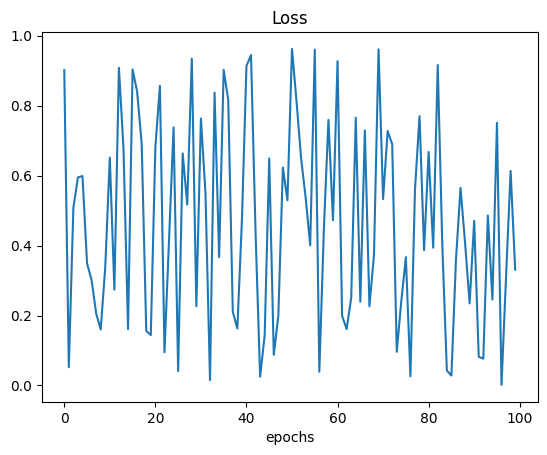

In [25]:
plt.figure()
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("epochs")

Text(0, 0.5, 'LR')

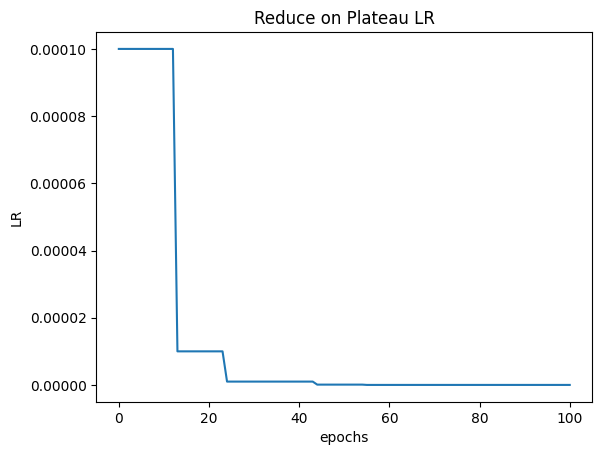

In [26]:
plt.figure()
plt.plot(lr_list)
plt.title("Reduce on Plateau LR")
plt.xlabel("epochs")
plt.ylabel("LR")